In [140]:
import pathlib
import matplotlib as mpl
import pandas as pd
import scanpy as sc
import seaborn as sns
from matplotlib.ticker import NullLocator
import matplotlib.lines as mlines
%matplotlib inline
from matplotlib import pyplot as plt
savefig_args = {
    "dpi": 300,
    "bbox_inches": "tight",
    "pad_inches": 0.2,
    "transparent": True,
}

mpl.rc("savefig", dpi=300)
output_dir = "/home/michaelswift/repos/tabula-bursa/analysis/figures/"
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)
sc._settings.figdir = output_dir
output_suffix = ""
output_formats = [".png",".pdf"]
def save_figure(
    fig,
    name,
    output_dir=output_dir,
    output_suffix=output_suffix,
    output_formats=output_formats,
    savefig_args=savefig_args,
):
    for output_format in output_formats:
        fig.savefig(
            output_dir + "/" + name + output_suffix + output_format, **savefig_args
        )
    return None
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 100)

plt.style.use('../bursa.mplstyle')
sns.set_style("ticks")

In [141]:
%run ../helper.py

<Figure size 960x720 with 0 Axes>

In [142]:
df = pd.read_table("../../../data/bcells.obs.tsv.gz")
df = df[df.probable_hq_single_b_cell == True]
df.loc[:,"locus"] = df.locus.fillna("Not Detected")
df.loc[:,"detected"] = df.locus.map({"IGH": "Detected", "Not Detected": "Not Detected"})
df.loc[:,"bcelltype"] = df.celltypist

/tmp/ipykernel_77282/817578543.py:1: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_table("../../../data/bcells.obs.tsv.gz")


In [143]:
df['bcelltype'] = df.celltypist.map(lambda x: celltypist_simpler.get(x,x))

In [144]:
df_detected_vdj = df[df.detected == "Detected"]

In [145]:
data = df_detected_vdj.groupby(['tissue', 'donor']).bcelltype.value_counts(normalize = True).reset_index()

In [146]:
selection = data.groupby('bcelltype').proportion.mean() > 0.0005
order = selection[selection].index

In [147]:
# Group the data and count the occurrences of each 'bcelltype' in each ['tissue', 'donor'] group
# Then reset the index to make it a DataFrame
data = df_detected_vdj.groupby(['tissue', 'donor', 'bcelltype']).size().reset_index(name='count')

# Create a pivot table to fill in missing 'bcelltype' for each ['tissue', 'donor'] group with 0
pivot_data = pd.pivot_table(data, values='count', index=['tissue', 'donor'], columns='bcelltype', fill_value=0)

# Normalize the counts to get the proportion and reset the index
normalized_data = pivot_data.div(pivot_data.sum(axis=1), axis=0).reset_index()


In [148]:
# Melt the DataFrame back to long form
melted_data = pd.melt(normalized_data, id_vars=['tissue', 'donor'], var_name='bcelltype', value_name='proportion')

# Add a pseudocount of 1e-5 to every proportion value
melted_data['proportion'] += 1e-6


In [149]:
melted_data = melted_data[melted_data.bcelltype.isin(order)]

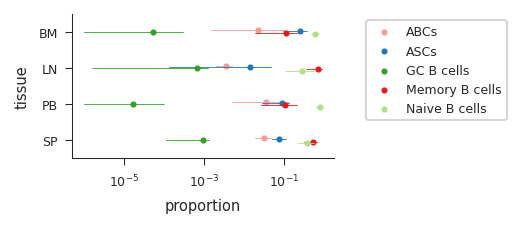

In [150]:
fig, ax = plt.subplots(1,1, figsize = (2.25, 1.25))
sns.pointplot(data = melted_data, y = 'tissue', hue = 'bcelltype', x = 'proportion', join = False, dodge=True, errorbar=('pi', 99.9), scale = 0.5, errwidth=0.4, palette=bcelltype_colors_alt)
ax.set_xscale("log")
sns.despine()
ax.legend(bbox_to_anchor = (1.1,1))